**Bigram Language Model (LM)**

In this notebook, I implement the non-neural network bigram model that Karpathy showed in his makemore series. Credit to Karpathy for the tutorial. Note that this notebook is my exercise on reimplmenting what he did in the video, in order to aid my own learning.

<br>

*Let's do this*  
<br>  
*1 - Bigrams*  

A bigram is simply refers to 2 (bi) characters/words/tokens. As an example, take the name

Emma
<br>
<br>
If we look at the set of bigrams in this name, or said another way, if we look at all 2 character sequences that occur in this name, we find that they are:

Em  
mm  
ma  

So the name Emma has 3 bigrams. Bigrams like this can be used to build langauge models.
<br>
<br>  

*2 - Langauge Model/LM*  


A language model is a machine learning model that generates text. You pass in some text to the model as input, then the model generates text continuing your input. For example,


Input               Output

How are -> Model -> you?

Such as language models can be character-based, token-based, or word-based. This refers to whether the LM generates characters, tokens, or words at a time. To understand this better, consider the previous example. If you pass the same input to a character-level LM, you get something like this happening.

Input                 Output

How are     -> Model -> y
How are y   -> Model -> o
How are yo  -> Model -> u
How are you -> Model -> ?

This actually happens under the hood in a character-based model. It generates a character (y), adds that character (y) to the input text, then passes the whole thing (input text + y) as the new input, generates another character and so on.

Since this happens under the hood, what you see is still:

Input               Output

How are -> Model -> you?


In this file, we build a character-level Language Model using bigrams that generates names. We will pass in a dataset/file that contains a list of ~32000 names. Then, we will create a LM that gets all the bigrams, counts how often each bigram occurs in the dataset, and then assigns probabilities to each bigram based on how often it occurs, meaning bigrams that occur more get a higher probability and vice versa.

The model can then generate new characters based on these probabilities. So, in the end, if you pass in a character, let's say 

c

The model will generate a character, likely a character that has a high probability

ca

and continue generating till it completes a name.

catherine

Though, bigram models are really weak, so most names will be gibberish.

Nonetheless, hopefully you now have some intuition of what we're here to do, so let's do this :)

In [1]:
import torch
import torch.nn.functional as F

Reading the list of names

In [2]:
text = ''

with open('names.txt', 'r', encoding = 'utf-8') as names:
    
    text = names.read().splitlines()

In [3]:
text

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [4]:
num_names  = len(text)
num_names

32033

In [5]:
text[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

We need to tell the model when a name starts and ends. To do that, a popular way in Natural Langauge Processing (NLP) is to add special characters.

Here, we'll add the special characer '.' (dot) to the start and end of each name

In [6]:
transform_text = lambda words: ['.' + word + '.' for word in words] 
transformed_text = transform_text(text)
transformed_text[:10]

['.emma.',
 '.olivia.',
 '.ava.',
 '.isabella.',
 '.sophia.',
 '.charlotte.',
 '.mia.',
 '.amelia.',
 '.harper.',
 '.evelyn.']

We're going to collect all the bigrams in the dataset, as well as how often they occur. Here, we'll use a trick to get bigrams. All the example is for 1 row here, we'll use the same idea over the entire dataset.

The intuition is that if you take a word, let's say 'emma', and then take a subset of the word starting from the 2nd letter (i.e. 'mma'), you can align them and get the bigrams

emma  
mma

Each column is a bigram. The last character on the 1st line has no corresponding character, so we don't include that column.


In [7]:
transformed_text[0]

'.emma.'

In [8]:
transformed_text[0][1:]

'emma.'

In [9]:
for ch1, ch2 in zip(transformed_text[0], transformed_text[0][1:]):
    print(ch1, ch2)

. e
e m
m m
m a
a .


A few key pieces of information we're going to store.

- Vocab: all possible characters that we can use to form a name. This includes 26 alphabet characters + the special .
- Length of Vocab: how many characters we have in Vocab
- itoc: A mapping of numbers to characters. Pass in a number, and you get the corresponding character
- ctoi: Vice versa to ^^

In [10]:
vocab = sorted(list(set(''.join(transformed_text))))
vocab_len = len(vocab)
itoc = {i:c for i, c in enumerate(vocab)}
ctoi = {c:i for i, c in itoc.items()}

In [11]:
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [12]:
vocab_len

27

In [13]:
itoc

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [14]:
ctoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [15]:
def get_bigrams(txt):
    
    bigrams = torch.ones(vocab_len, vocab_len, dtype = torch.long)
    
    for i in range(len(txt)):
        
        for ch1, ch2 in zip(txt[i], txt[i][1:]):
            
            idx1, idx2 = ctoi[ch1], ctoi[ch2]
            bigrams[idx1, idx2] += 1
    
    return bigrams


We can get the all the bigrams from the text file. The result we get is a matrix, where each row is like

character A  --------------------------   how many times this character follows character A

a ----------------------------------------.  a  b  c  d  (and so on)

-------------------------------------------5  6  7  8  9  (and so on)


The matrix only has the numbers. I added the description above for explanation. I also made up the above numbers.
Since we have 27 characters, and each character can be followed by any of the same 27 characters, we have a 27 x 27 matrix

In [16]:
bigrams = get_bigrams(transformed_text)
bigrams.shape

torch.Size([27, 27])

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline


Let's build a nice diagram of the bigrams and their counts

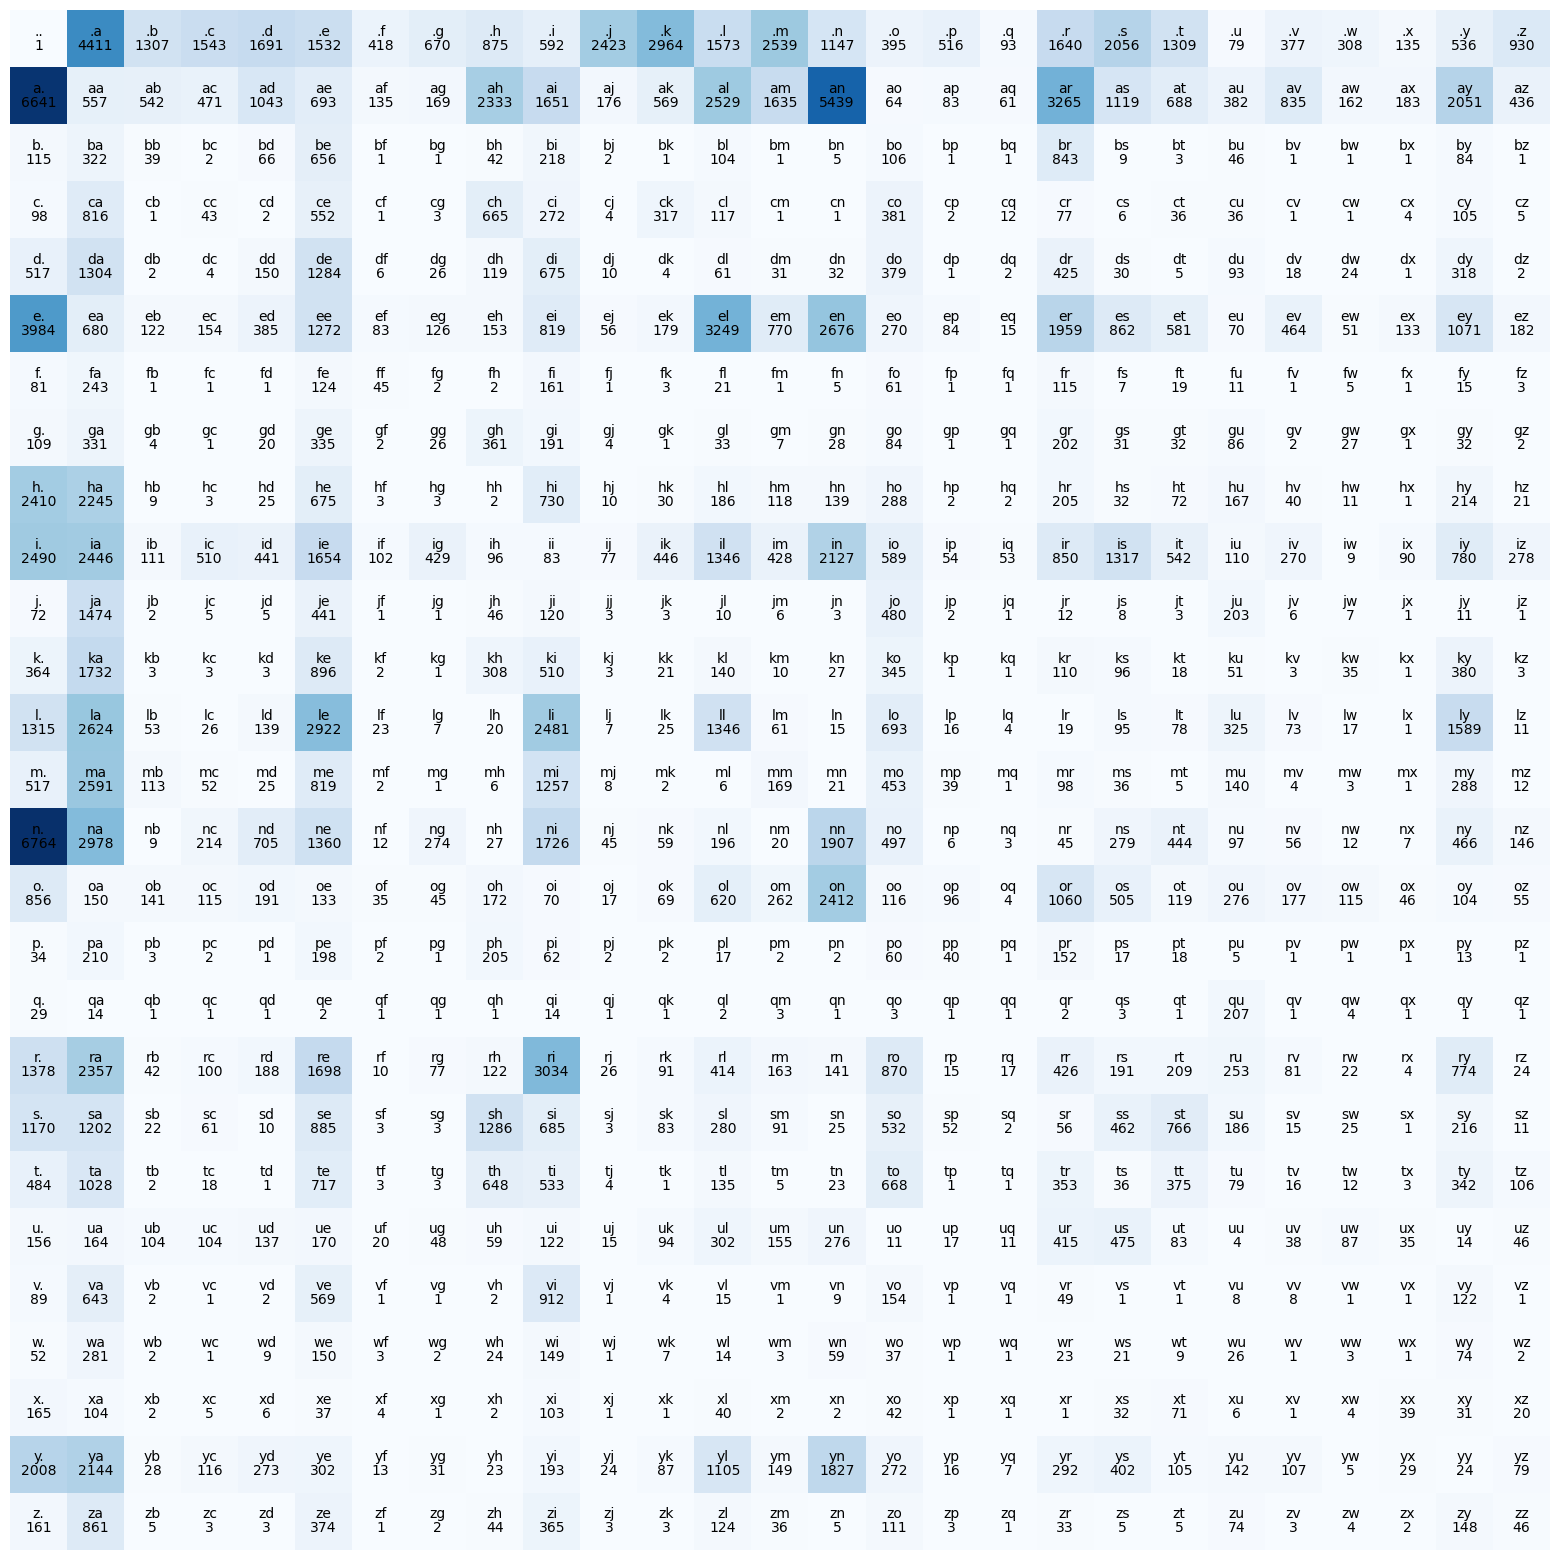

In [18]:
def plot_bigrams(grams):
    
    plt.figure(figsize = (20, 20))
    plt.imshow(grams, cmap = 'Blues')
    
    for c1_idx in range(vocab_len):
        for c2_idx in range(vocab_len):
            
            bigram = itoc[c1_idx] + itoc[c2_idx]
            count = grams[c1_idx, c2_idx].item()
            plt.text(c2_idx, c1_idx, bigram, ha = 'center', va = 'bottom')
            
            if grams.dtype != torch.int32 and grams.dtype != torch.int64 and grams.dtype != torch.long:
                plt.text(c2_idx, c1_idx, f"{count:.2f}", ha = 'center', va = 'top')
            
            else:
                plt.text(c2_idx, c1_idx, count, ha = 'center', va = 'top')
    
    plt.axis('off')    

plot_bigrams(bigrams)    

In [19]:
floaty_bigrams = bigrams.float()
floaty_bigrams[0]

tensor([1.0000e+00, 4.4110e+03, 1.3070e+03, 1.5430e+03, 1.6910e+03, 1.5320e+03,
        4.1800e+02, 6.7000e+02, 8.7500e+02, 5.9200e+02, 2.4230e+03, 2.9640e+03,
        1.5730e+03, 2.5390e+03, 1.1470e+03, 3.9500e+02, 5.1600e+02, 9.3000e+01,
        1.6400e+03, 2.0560e+03, 1.3090e+03, 7.9000e+01, 3.7700e+02, 3.0800e+02,
        1.3500e+02, 5.3600e+02, 9.3000e+02])

In [20]:
bigram_probs = floaty_bigrams/floaty_bigrams.sum()

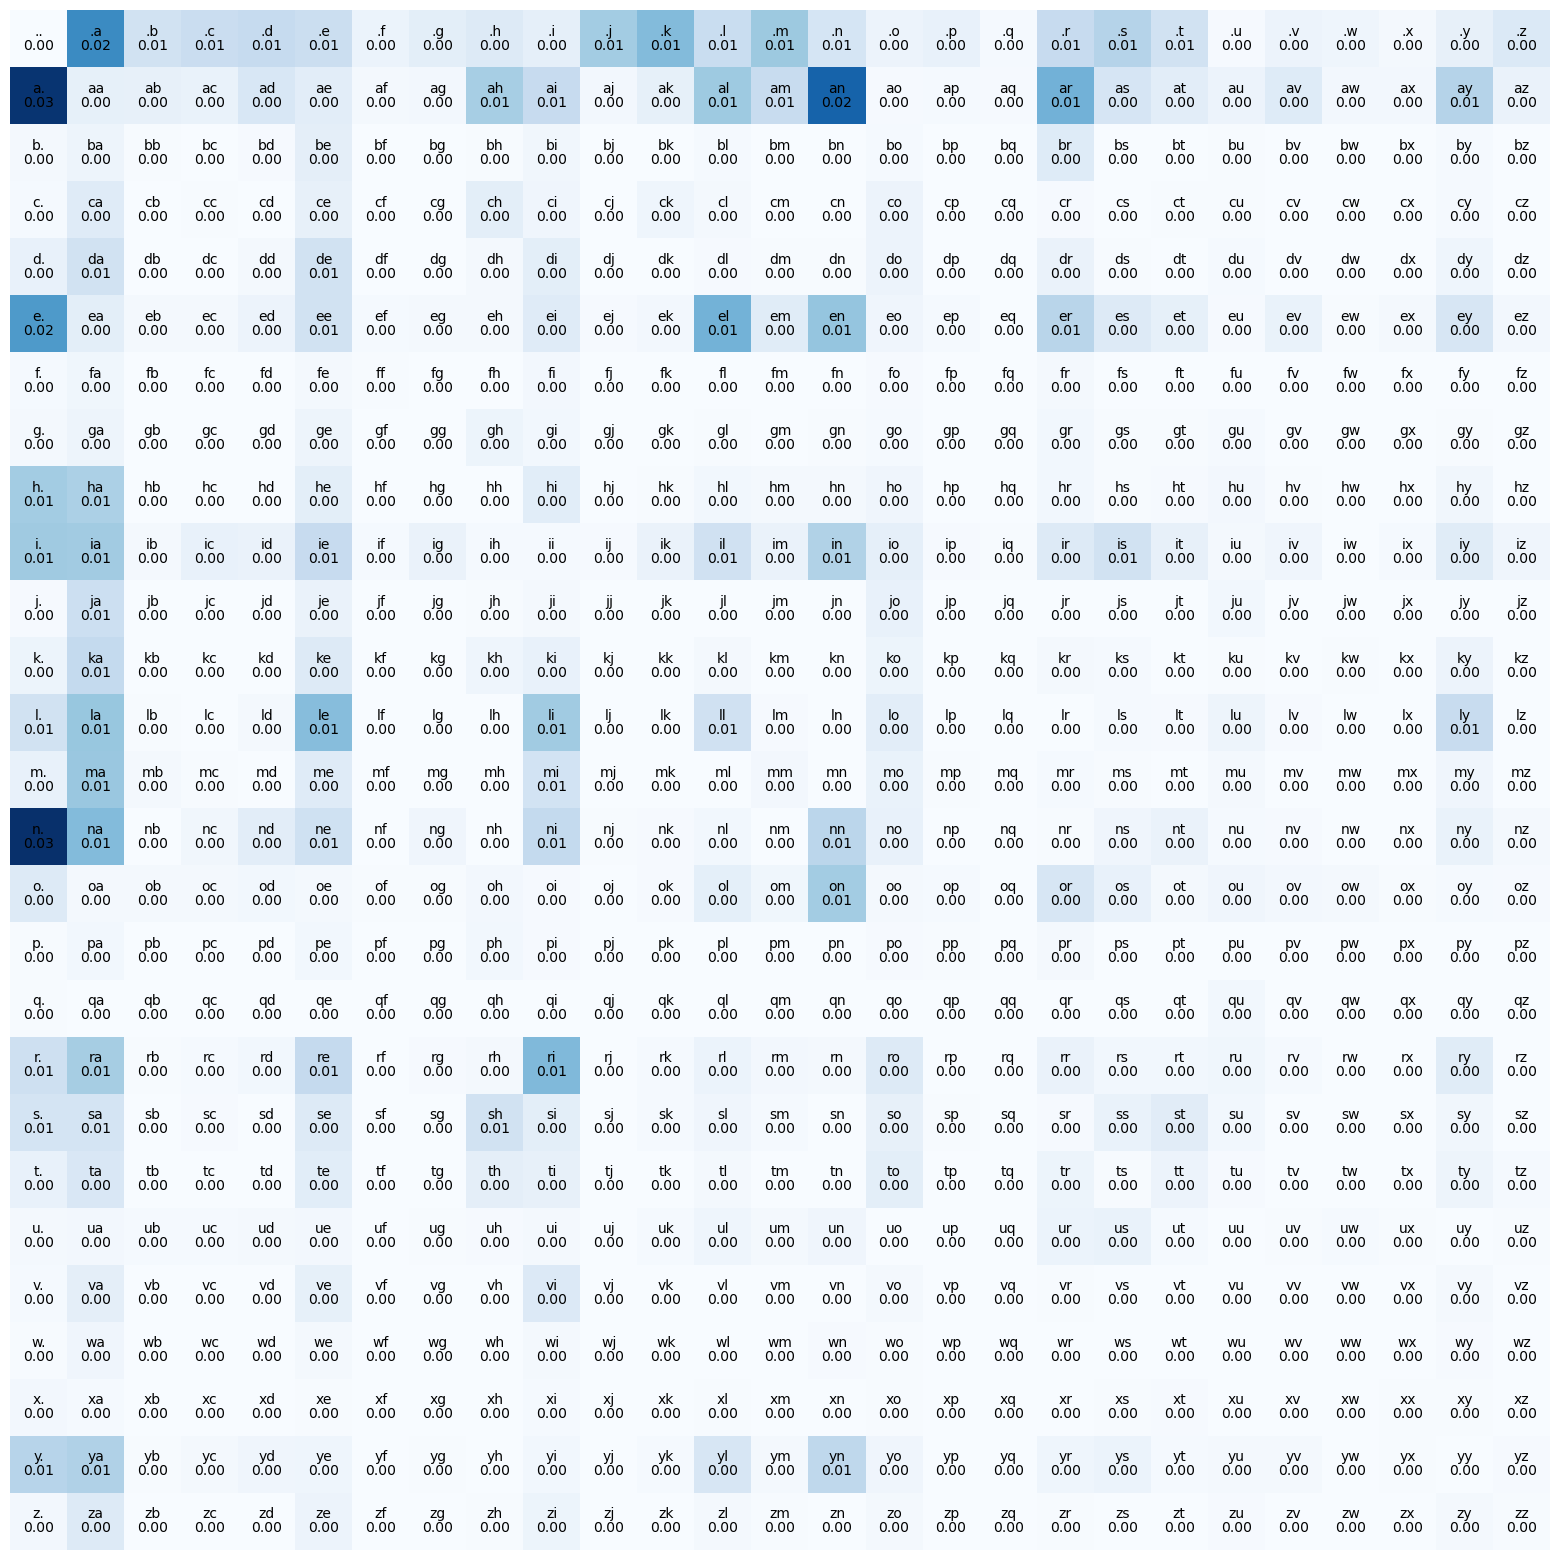

In [21]:
plot_bigrams(bigram_probs)

In [22]:
torch.multinomial(bigram_probs[0], num_samples = 50, replacement = True)


tensor([ 4, 10, 15, 13,  3, 13, 11, 13,  3, 18, 13, 13, 11, 11, 13, 13, 19, 12,
         7, 10,  5,  5,  1, 13, 13, 19,  5, 26,  4,  2, 22,  1, 13, 26,  5, 18,
        14, 12,  1, 18, 20, 19, 10, 11, 11,  8, 10,  1, 19,  1])

In [45]:
def generate(input_chr, max_len = 10):
    
    idx = ctoi[input_chr]
    
    if input_chr != '.':
        print(input_chr, end='')
    else:
        do_nothing = 'do_nothing'
    
    for i in range(max_len):
        idx = torch.multinomial(bigram_probs[idx], num_samples = 1, replacement = True).item()
        
        if idx == 0:
            return
        
        char = itoc[idx]
        print(char, end='')
        

In [80]:
generate('a')

anzamiortan

In [81]:
times = 1

for i in range(times):
    for j in range(27):
        c = itoc[j]
        generate(c)
        print()

tiahontra
aasikeroco
brin
cole
deny
e
farigh
gon
hin
imahae
jw
kox
lirynn
men
ni
olia
prlorilla
qurgoliosa
r
sanganent
tiladlynaga
ua
vestyle
wnin
xomeli
ylr
zanna


In [94]:
transformed_text[0]

'.emma.'

In [96]:
for c1, c2 in zip(transformed_text[0], transformed_text[0][1:]):
    print(c1, c2)

. e
e m
m m
m a
a .


In [118]:
log_l, neg_log_l, avg_neg_log_l = nll(transformed_text[15])

print(f'{log_l=}')
print(f'{neg_log_l=}')
print(f'{avg_neg_log_l=}')


log_l=tensor(-30.7458)
neg_log_l=tensor(30.7458)
avg_neg_log_l=tensor(5.1243)


In [104]:
def nll(word):
    
    n = 0
    log_likelihood = 0
    
    for c1, c2 in zip(word, word[1:]):
        
        i1 = ctoi[c1]
        i2 = ctoi[c2]
        prob = bigram_probs[i1, i2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
    
    nll = -log_likelihood
    avg_nll = nll/n
    
    return log_likelihood, nll, avg_nll

In [97]:
'hello'[1:]

'ello'